In [1]:
from astropy import units as u
from astropy import coordinates as coord
from astroquery.vizier import Vizier
from astroquery.utils.tap.core import TapPlus
import ligo.skymap.plot
from plotsettings import *

In [2]:
def query_askap(COORD, RADIUS):
    
    # Reference: Hale et al. (2021), https://arxiv.org/abs/2109.00956
    # Frequency: 887.5 MHz
    
    casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")

    query = "SELECT * FROM  AS110.racs_dr1_gaussians_galacticcut_v2021_08_v01 \
            where 1=CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra:.4f}, {dec:.4f}, {radius:.4f}))".format(ra=COORD.ra.deg, dec=COORD.dec.deg, radius=RADIUS.to(u.deg).value)
    
    job = casdatap.launch_job_async(query)

    result = job.get_results()
    
    if len(result) > 0:
        
        _coords_askap = coord.SkyCoord(result['ra'], result['dec'])
        
        keys = result.keys()
        
        result['_r'] = _coords_askap.separation(COORD).to(u.arcmin).value
        result['_r'].format = '.4f'
        result.sort('_r')
        
        return result[['_r'] + keys]
    
    else:
        return None

def query_vlass(COORD, RADIUS):
    
    # Reference: Gordon et al. (2021), https://arxiv.org/abs/2102.11753
    # Frequency: 3 GHz
    
    v = Vizier(columns = ['all'], catalog = 'J/ApJS/255/30', row_limit = -1)
    result = v.query_region(COORD, radius = RADIUS, catalog='J/ApJS/255/30')

    if len(result) > 0:
        result = result['J/ApJS/255/30/comp']
        result.sort('_r')
        return result
    
    else:
        return None

def query_first(COORD, RADIUS):
    
    # Reference: White et al. (1997), https://ui.adsabs.harvard.edu/abs/1997ApJ...475..479W/abstract
    # Frequency: 1.4 GHz
    
    v = Vizier(columns = ['all'], catalog = 'VIII/90', row_limit = -1)
    result = v.query_region(COORD, radius = RADIUS, catalog='VIII/90')

    if len(result) > 0:
        result = result['VIII/90/first12']
        result.sort('_r')
        return result
    
    else:
        return None

def query_nvss(COORD, RADIUS):

    # Reference: White et al. (1997), https://ui.adsabs.harvard.edu/abs/1997ApJ...475..479W/abstract
    # Frequency: 1.4 GHz
    
    v = Vizier(columns = ['all'], catalog = 'VIII/65', row_limit = -1)
    result = v.query_region(COORD, radius = RADIUS, catalog='VIII/65')

    if len(result) > 0:
        result = result['VIII/65/nvss']
        result.sort('_r')
        return result
    
    else:
        return None


# Object properties

In [3]:
coordinates = coord.SkyCoord('13:09:48.082', '-23:22:53.28', unit=(u.hour, u.deg))
coordinates = coord.SkyCoord(183.475, 11.236, unit=u.deg)
coordinates

<SkyCoord (ICRS): (ra, dec) in deg
    (183.475, 11.236)>

# Search radius

In [4]:
radius = 60*u.arcmin

# Queries

ASKAP query can fail if you use large search areas

In [5]:
result_askap = query_askap(coordinates, radius)

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
result_first = query_first(coordinates, radius)

In [7]:
result_nvss = query_nvss(coordinates, radius)

In [8]:
result_vlass = query_vlass(coordinates, radius)

In [9]:
# Plot results

''

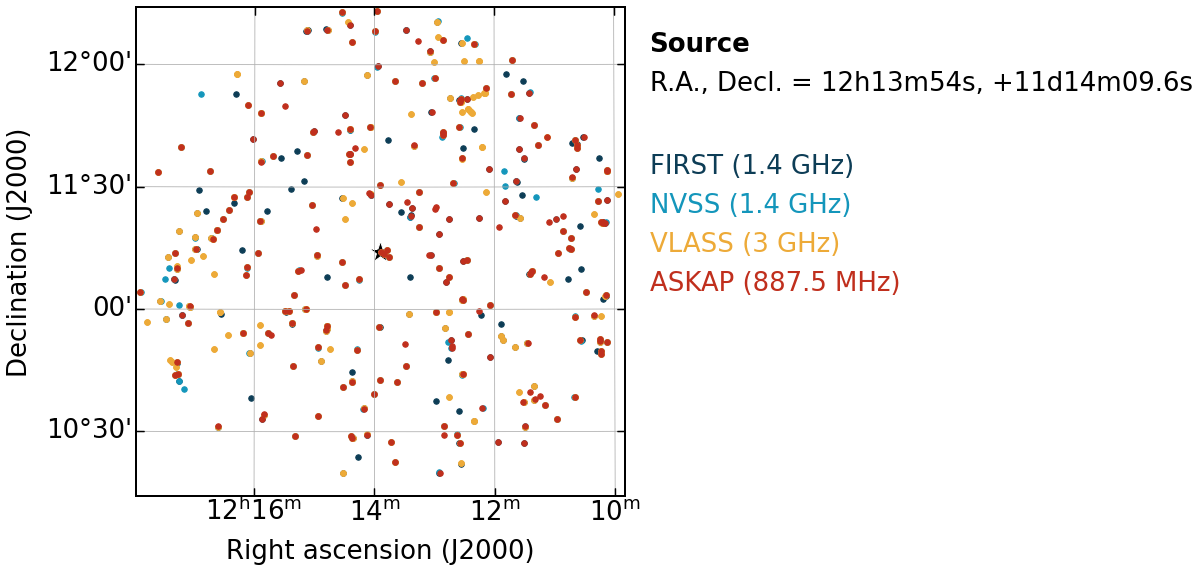

In [10]:
color_source = 'black'
color_first  = vigit_color_1
color_nvss   = vigit_color_4
color_vlass  = vigit_color_8
color_askap  = vigit_color_12

plt.figure(figsize=(9, 9))

ax = plt.axes(projection='astro zoom',
              center=coordinates, radius=radius)#, rotate='20 deg')

ax.scatter(coordinates.ra.deg, coordinates.dec.deg, transform=ax.get_transform('fk5'),
                    s=500, marker='*', facecolor=color_source, edgecolor='white', zorder=0)

if result_first is not None:
    for ii in range(len(result_first)):
        _coordinates = coord.SkyCoord(result_first['RAJ2000'][ii].replace(' ', ':'), result_first['DEJ2000'][ii].replace(' ', ':'), unit=(u.hour, u.deg))
        ax.scatter(_coordinates.ra.deg, _coordinates.dec.deg, transform=ax.get_transform('fk5'),
                    s=30, marker='o', facecolor=color_first)

if result_nvss is not None:
    for ii in range(len(result_nvss)):
        _coordinates = coord.SkyCoord(result_nvss['RAJ2000'][ii].replace(' ', ':'), result_nvss['DEJ2000'][ii].replace(' ', ':'), unit=(u.hour, u.deg))
        ax.scatter(_coordinates.ra.deg, _coordinates.dec.deg, transform=ax.get_transform('fk5'),
                    s=30, marker='o', facecolor=color_nvss)

if result_vlass is not None:
    for ii in range(len(result_vlass)):
        ax.scatter(result_vlass['RAJ2000'][ii], result_vlass['DEJ2000'][ii], transform=ax.get_transform('fk5'),
                    s=30, marker='o', facecolor=color_vlass)

if result_vlass is not None:
    for ii in range(len(result_vlass)):
        ax.scatter(result_vlass['RAJ2000'][ii], result_vlass['DEJ2000'][ii], transform=ax.get_transform('fk5'),
                    s=30, marker='o', facecolor=color_vlass)

if result_askap is not None:
    for ii in range(len(result_askap)):
        ax.scatter(result_askap['ra'][ii], result_askap['dec'][ii], transform=ax.get_transform('fk5'),
                    s=30, marker='o', facecolor=color_askap)


# Prettify
        
ax.grid()

ax.set_xlabel('Right ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

text_kwargs = {'ha': 'left', 'va': 'top', 'fontsize':label_size, 'transform':ax.transAxes}

_coordinates = coordinates.to_string('hmsdms')
label = 'R.A., Decl. = {ra}, {dec}'.format(ra=_coordinates.split(' ')[0], dec=_coordinates.split(' ')[1])

plt.text(right + 0.05, top-0.05, 'Source',            color='black', fontweight='bold', **text_kwargs)
plt.text(right + 0.05, top-0.13, label,               color='black', **text_kwargs)
plt.text(right + 0.05, top-0.30, 'FIRST (1.4 GHz)',   color=color_first, **text_kwargs)
plt.text(right + 0.05, top-0.38, 'NVSS (1.4 GHz)',    color=color_nvss , **text_kwargs)
plt.text(right + 0.05, top-0.46, 'VLASS (3 GHz)',     color=color_vlass, **text_kwargs)
plt.text(right + 0.05, top-0.54, 'ASKAP (887.5 MHz)', color=color_askap, **text_kwargs)
;

In [11]:
# Show query outputs

If you search radius is in arcmin, the distance '_r' is in units of arcmin

In [12]:
result_first

_r,recno,FIRST,FITS,RAJ2000,DEJ2000,p_S_,Fpeak,Fint,Rms,MajAxis,MinAxis,PA,fMaj,fMin,fPA,Field,N1,r1,m1,c1,N2,r2,m2
,,,,'h:m:s','d:m:s',,mJy,mJy,mJy,arcsec,arcsec,deg,arcsec,arcsec,deg,,,arcsec,mag,,,arcsec,mag
float64,int32,str16,str4,str12,str12,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,str12,int16,float32,float32,str1,int16,float32,float32
0.0360,578992,J121353.9+111411,FITS,12 13 53.926,+11 14 11.45,0.014,50.77,64.40,0.143,3.79,1.51,71.2,6.60,5.61,71.2,12150+11200I,0,--,--,,0,--,--
1.1130,579173,J121350.0+111336,FITS,12 13 50.060,+11 13 36.47,0.014,3.52,3.16,0.140,0.00,0.00,89.7,5.15,5.10,89.7,12150+11200I,0,--,--,,0,--,--
1.6246,578881,J121347.5+111431,FITS,12 13 47.539,+11 14 31.10,0.014,1.49,1.38,0.142,2.64,0.00,177.9,6.01,4.52,177.9,12150+11200I,1,0.94,20.44,g,0,--,--
2.5785,579417,J121345.0+111247,FITS,12 13 45.097,+11 12 47.30,0.014,4.47,4.47,0.137,0.00,0.00,90.0,5.40,5.40,90.0,12150+11200I,0,--,--,,0,--,--
8.5389,581162,J121415.3+110724,FITS,12 14 15.324,+11 07 24.58,0.014,2.90,3.30,0.146,3.05,0.00,172.5,6.20,5.37,172.5,12150+11200I,0,--,--,,0,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59.5059,590168,J121040.1+103825,FITS,12 10 40.144,+10 38 25.69,0.016,1.90,1.98,0.133,1.96,0.00,0.1,5.74,5.28,0.1,12120+10273I,1,0.38,20.65,g,0,--,--
59.6970,586096,J121008.0+105200,FITS,12 10 08.077,+10 52 00.28,0.014,6.23,5.90,0.151,0.32,0.00,40.2,5.41,5.10,40.2,12090+10536I,3,0.07,18.89,g,0,--,--


In [13]:
result_nvss

_r,recno,Field,Xpos,Ypos,NVSS,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,S1.4,e_S1.4,l_MajAxis,MajAxis,l_MinAxis,MinAxis,PA,e_MajAxis,e_MinAxis,e_PA,f_resFlux,resFlux,polFlux,polPA,e_polFlux,e_polPA,Image
,,,pix,pix,,'h:m:s','d:m:s',s,arcsec,mJy,mJy,,arcsec,,arcsec,deg,arcsec,arcsec,deg,,mJy,mJy,deg,mJy,deg,
float64,int32,str8,float32,float32,str14,str11,str11,float32,float32,float64,float32,str1,float32,str1,float32,float32,float32,float32,float32,str2,int16,float32,float32,float32,float32,str5
0.0360,904207,C1216P12,635.69,329.85,121353+111411,12 13 53.89,+11 14 11.0,0.03,0.6,64.0,2.0,<,18.8,<,15.4,--,--,--,--,P*,21,1.76,-14.4,0.46,5.1,Image
2.5579,904039,C1216P12,644.35,324.48,121345+111250,12 13 45.07,+11 12 50.3,0.23,3.4,5.5,0.5,<,54.1,<,36.7,--,--,--,--,P*,21,0.11,38.2,0.63,90.0,Image
8.6639,904645,C1216P12,614.54,302.21,121415+110717,12 14 15.49,+11 07 17.0,0.43,5.2,4.5,0.5,<,91.0,<,39.1,--,--,--,--,,--,0.62,58.5,0.93,20.6,Image
9.7275,904976,C1216P12,598.15,319.13,121432+111131,12 14 32.18,+11 11 31.2,0.13,1.9,8.3,0.5,<,32.7,<,28.3,--,--,--,--,,--,-0.05,--,0.49,--,Image
11.2707,903593,C1216P12,664.58,364.27,121324+112246,12 13 24.35,+11 22 46.4,0.16,3.8,9.4,1.1,,50.1,<,36.1,-17.5,9.0,--,9.0,,--,-0.01,--,1.01,--,Image
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59.3381,900259,C1216P12,825.88,188.03,121040+103833,12 10 40.59,+10 38 33.7,0.52,8.1,2.2,0.4,<,75.2,<,59.4,--,--,--,--,,--,0.77,-76.1,0.49,12.0,Image
59.3793,904978,C1216P12,597.81,564.24,121432+121247,12 14 32.20,+12 12 47.9,0.28,4.8,4.4,0.5,<,65.9,<,38.5,--,--,--,--,,--,-0.06,--,0.65,--,Image


In [14]:
result_vlass

_r,recno,CompName,CompId,IslId,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Ftot,e_Ftot,Fpeak,e_Fpeak,Maj,e_Maj,Min,e_Min,PA,e_PA,FtotIsl,e_FtotIsl,Islrms,Islmean,ResIdIslrms,ResidIslmean,RAMdeg,DEMdeg,e_RAMdeg,e_DEMdeg,SCode,Xposn,e_Xposn,Yposn,e_Yposn,XposnMax,e_XposnMax,YposnMax,e_YposnMax,MajImgPlane,e_MajImgPlane,MinImgPlane,e_MinImgPlane,PAImgPlane,e_PAImgPlane,DCMaj,e_DCMaj,DCMin,e_DCMin,DCPA,e_DCPA,DCMajImgPlane,e_DCMajImgPlane,DCMinImgPlane,e_DCMinImgPlane,DCPAImgPlane,e_DCPAImgPlane,Tile,Subtile,RASdeg,DESdeg,NVSSdist,FIRSTdist,PeakToRing,DupFlag,QualFlag,NNdist,BMaj,BMin,BPA,MainSample,QLcutout
,,,,,deg,deg,deg,deg,mJy,mJy,mJy / beam,mJy / beam,arcsec,arcsec,arcsec,arcsec,deg,deg,mJy,mJy,mJy / beam,mJy / beam,mJy / beam,mJy / beam,deg,deg,deg,deg,,pix,pix,pix,pix,pix,pix,pix,pix,arcsec,arcsec,arcsec,arcsec,deg,deg,arcsec,arcsec,arcsec,arcsec,deg,deg,arcsec,arcsec,arcsec,arcsec,deg,deg,,,deg,deg,arcsec,arcsec,,,,arcsec,arcsec,arcsec,deg,,
float64,int32,str31,int16,int16,float64,float64,float64,float64,float64,float32,float64,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,str14,float64,float64,float64,float64,float64,uint8,uint8,float64,float32,float32,int16,uint8,str237
0.0384,1725935,VLASS1QLCIR J121353.91+111411.5,38,36,183.47465937,11.23654076,0.00000324,0.00000646,32.296,0.423,15.574,0.139,4.2677,0.0549,2.8378,0.0272,85.2114,1.3926,34.421,0.479,0.139,-0.002,0.216,0.180,183.47495428,11.23626005,0.00000324,0.00000646,M,2180.78680,0.01168,911.60079,0.02324,2179.74581,0.01168,910.5899,0.0232,4.2677,0.0549,2.8377,0.0272,85.2291,1.3926,3.3973,0.0549,0.7267,0.0272,73.4563,1.3926,3.3973,0.0549,0.7267,0.0272,73.4740,1.3926,T13t19,J121415+113000,183.56551,11.50000,0.73027,0.14407,24.2466,0,0,66.47000,3.05,2.21,-50,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T13t19.J121415%2B113000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Djb3qnrr8058i0m3x&CIRCLE=183.47465937487368+11.23654076096146+0.025
1.1088,1725797,VLASS1QLCIR J121350.06+111336.9,40,38,183.45858945,11.22692669,0.00004808,0.00003164,2.136,0.313,1.548,0.141,4.0066,0.4581,2.3246,0.1679,119.3659,8.8006,2.280,0.294,0.140,-0.001,0.098,0.010,183.45858945,11.22692669,0.00004808,0.00003164,S,2237.54209,0.17309,877.01003,0.11390,2237.54209,0.17309,877.0100,0.1139,4.0065,0.4581,2.3246,0.1679,119.3867,8.8006,2.6447,0.4581,0.5155,0.1679,112.6328,8.8006,2.6447,0.4581,0.5155,0.1679,112.6536,8.8006,T13t19,J121415+113000,183.56551,11.50000,65.80928,0.46614,3.0849,0,0,66.13000,3.05,2.21,-50,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T13t19.J121415%2B113000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Djb3qnrr8058i0m3x&CIRCLE=183.45858944533046+11.22692668827872+0.025
1.6291,1725697,VLASS1QLCIR J121347.52+111431.5,41,39,183.44802991,11.24209657,0.00005215,0.00003898,1.134,0.264,1.013,0.141,2.9673,0.4430,2.5470,0.3292,84.4384,39.7670,1.023,0.211,0.138,0.000,0.028,0.001,183.44802991,11.24209657,0.00005215,0.00003898,S,2274.80707,0.18774,931.63559,0.14034,2274.80707,0.18774,931.6356,0.1403,2.9673,0.4430,2.5470,0.3292,84.4613,39.7670,0.0000,0.4430,0.0000,0.3292,0.0000,39.7670,0.0000,0.4430,0.0000,0.3292,0.0000,39.7670,T13t19,J121415+113000,183.56551,11.50000,95.87386,0.48036,3.0325,0,0,66.13000,3.05,2.21,-50,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T13t19.J121415%2B113000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Djb3qnrr8058i0m3x&CIRCLE=183.448029911949+11.242096574697248+0.025
2.5790,1725612,VLASS1QLCIR J121345.09+111247.2,42,40,183.43790839,11.21311749,0.00001996,0.00001819,2.461,0.238,2.470,0.134,3.1531,0.2082,2.1329,0.0952,130.911

In [15]:
result_askap

_r,id,catalogue_id,gaussian_id,source_id,tile_id,sbid,obs_start_time,n_gaus,ra,dec,e_ra,e_dec,total_flux_gaussian,e_total_flux_gaussian_pybdsf,e_total_flux_gaussian,total_flux_source,e_total_flux_source_pybdsf,e_total_flux_source,peak_flux,e_peak_flux,maj_axis,e_maj_axis,min_axis,e_min_axis,pa,e_pa,dc_maj,e_dc_maj,dc_min,e_dc_min,dc_pa,e_dc_pa,s_code,separation_tile_centre,noise,gal_lon,gal_lat
,,,,,,,,,deg,deg,arcsec,arcsec,mJy,mJy,mJy,mJy,mJy,mJy,mJy / beam,mJy / beam,arcsec,arcsec,arcsec,arcsec,deg,deg,arcsec,arcsec,arcsec,arcsec,deg,deg,,deg,mJy / beam,deg,deg
float64,int64,int64,str19,str19,str13,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64
0.0387,1252265,4549,RACS_1212+12A_2244,RACS_1212+12A_1950,RACS_1212+12A,8570,58597.616,1,183.474592,11.236506,0.04,0.04,93.251,0.653,7.058,93.251,0.653,7.058,92.212,0.374,25.27,0.1,25.02,0.1,76.64,16.76,3.65,0.1,0.91,0.1,76.64,16.76,S,1.3798,0.373,272.087959,71.822899
1.1166,1252274,4549,RACS_1212+12A_2259,RACS_1212+12A_1964,RACS_1212+12A,8570,58597.616,1,183.458579,11.226676,0.71,0.76,4.781,0.601,1.029,4.781,0.601,1.029,5.075,0.361,25.04,1.84,23.52,1.62,31.46,47.49,0.0,1.84,0.0,1.62,0.0,47.49,S,1.386,0.367,272.058073,71.806889
1.5870,1252277,4549,RACS_1212+12A_2266,RACS_1212+12A_1970,RACS_1212+12A,8570,58597.616,1,183.44893,11.242764,2.55,2.18,6.724,1.298,1.621,6.724,1.298,1.621,2.776,0.396,41.01,6.04,36.92,5.11,79.93,59.11,32.51,6.04,27.16,5.11,79.93,59.11,S,1.3683,0.367,272.007231,71.816713
2.5829,1252279,4549,RACS_1212+12A_2273,RACS_1212+12A_1976,RACS_1212+12A,8570,58597.616,1,183.437879,11.213034,0.64,0.71,7.337,0.71,1.237,7.337,0.71,1.237,6.319,0.37,27.97,1.7,25.95,1.47,156.54,32.99,12.54,1.7,6.95,1.47,156.54,32.99,S,1.3952,0.358,272.020905,71.785359
8.5601,1252234,4549,RACS_1212+12A_2188,RACS_1212+12A_1900,RACS_1212+12A,8570,58597.616,1,183.564082,11.12323,1.16,1.02,4.93,0.807,1.169,4.93,0.807,1.169,4.481,0.437,27.26,2.76,25.23,2.37,102.96,53.07,10.86,2.76,3.37,2.37,102.96,53.07,S,1.5111,0.427,272.504709,71.763039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59.4848,1252654,4549,RACS_1212+12A_2904,RACS_1212+12A_2517,RACS_1212+12A,8570,58597.616,1,182.667224,10.641104,1.6,1.82,5.156,0.928,1.266,5.156,0.928,1.266,3.011,0.368,34.63,4.41,30.92,3.62,24.14,46.79,23.96,4.41,18.19,3.62,24.14,46.79,S,1.9986,0.34,270.784791,70.923056
59.6836,1252721,4549,RACS_1212+12A_2994,RACS_1212+12A_2595,RACS_1212+12A,8570,58597.616,2,182.556633,10.815362,0.51,0.8,7.031,0.715,1.223,25.658,1.034,2.518,6.801,0.4,28.67,1.9,22.55,1.18,10.48,10.99,0.0,1.9,0.0,1.18,0.0,10.99,M,1.8613,0.401,270.233855,71.022613
